# Neural Network Challenge

Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import time

## Data

Financial Distress dataset found at https://www.kaggle.com/shebrahimi/financial-distress/home contains information on the financial standing of multiple companies at different points in time.

In [2]:
# financial data
financial = pd.read_csv('~/Desktop/Data_Science/Financial_Distress.csv')

In [3]:
financial.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [4]:
financial.columns

Index(['Company', 'Time', 'Financial Distress', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16',
       'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26',
       'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36',
       'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46',
       'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56',
       'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66',
       'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76',
       'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83'],
      dtype='object')

In [5]:
financial.shape

(3672, 86)

In [6]:
financial.describe()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3.672000e+03,3672.000000,3672.000000,3672.000000,...,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,182.084423,7.528322,1.040257,1.387820,0.129706,0.615769,8.681599e-01,0.154949,0.106717,0.784031,...,86.839822,91.920506,89.115908,17.780855,15.198708,-2.664305,19.714597,1.100488,13.122277,33.044935
std,117.024636,4.064016,2.652227,1.452926,0.120013,0.177904,5.719519e-01,0.124904,0.210555,1.033606,...,16.706209,64.656504,64.349382,2.040152,2.828648,8.192663,7.508588,2.666733,9.465907,13.714563
min,1.000000,1.000000,-8.631700,0.075170,-0.258080,0.016135,5.350000e-07,-0.269790,-0.627750,0.035160,...,54.806000,24.318000,23.776000,15.250000,12.000000,-20.200000,1.000000,-0.499220,1.000000,2.000000
25%,80.000000,4.000000,0.172275,0.952145,0.048701,0.501888,5.525575e-01,0.070001,-0.027754,0.436003,...,79.951000,39.800000,38.377000,16.000000,13.000000,-7.000000,14.000000,0.189912,6.000000,21.000000
50%,168.000000,7.000000,0.583805,1.183600,0.107530,0.638690,7.752450e-01,0.131830,0.104325,0.641875,...,90.000000,66.120000,59.471000,17.000000,14.500000,0.200000,20.000000,0.594765,11.000000,34.000000
75%,264.250000,11.000000,1.351750,1.506475,0.188685,0.749425,1.039000e+00,0.219570,0.231230,0.896773,...,93.883000,130.500000,132.400000,20.000000,16.000000,2.100000,26.000000,1.355050,17.000000,44.000000
max,422.000000,14.000000,128.400000,51.954000,0.749410,0.967900,6.835600e+00,0.858540,0.929550,38.836000,...,120.870000,227.500000,214.500000,22.000000,22.000000,8.600000,37.000000,128.400000,49.000000,74.000000


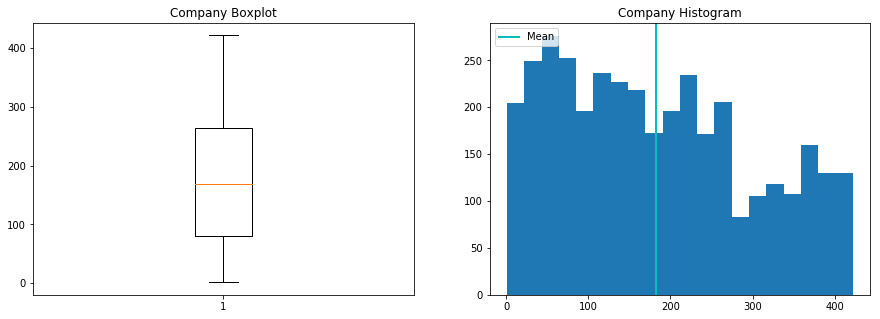

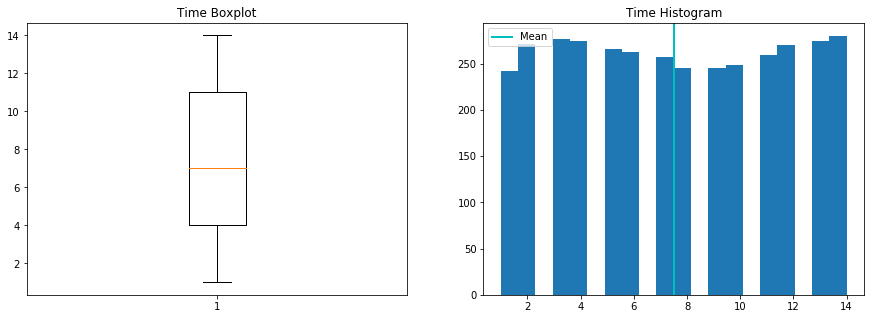

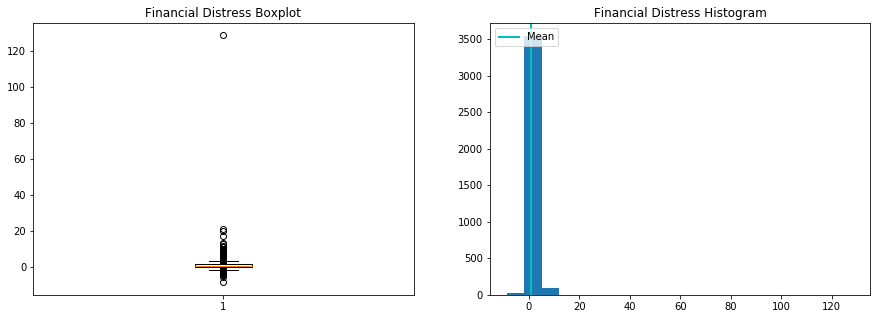

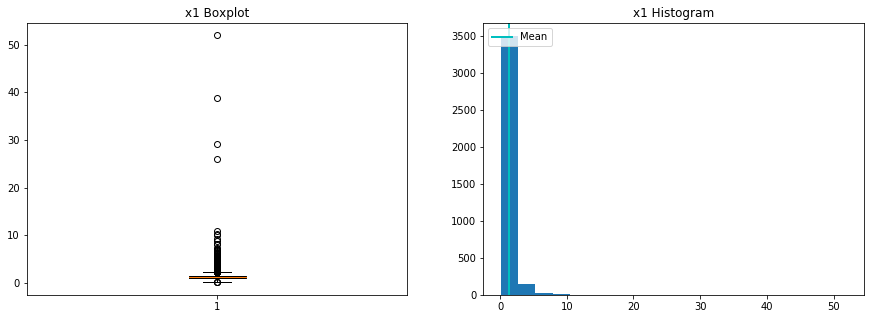

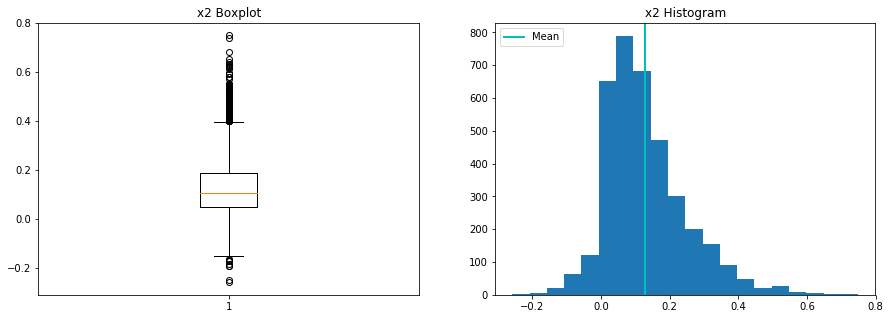

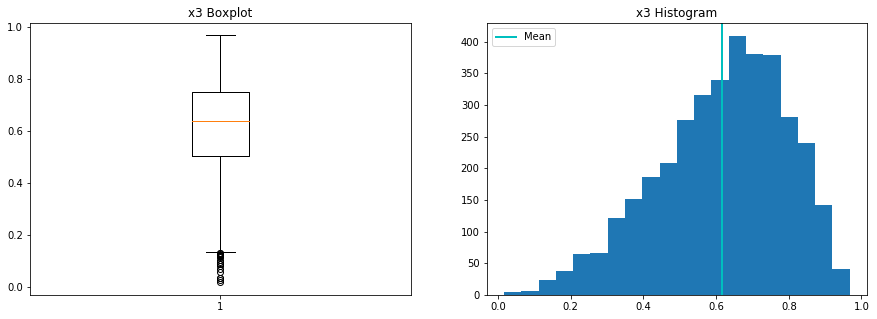

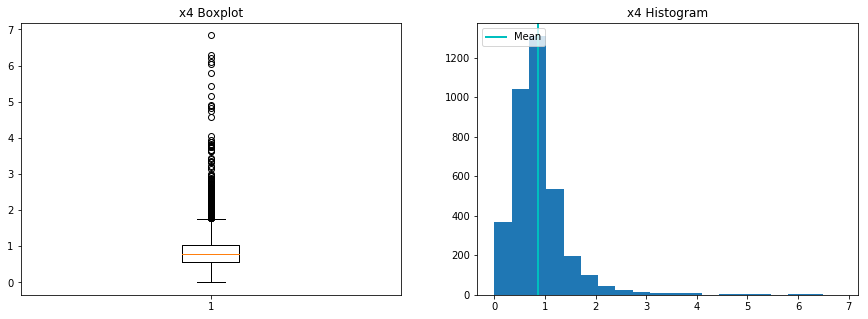

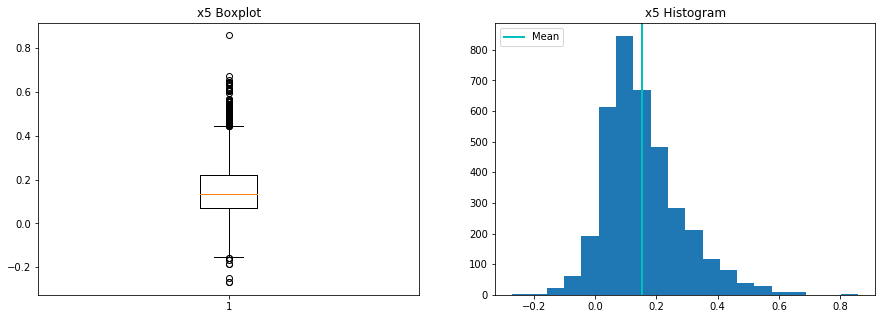

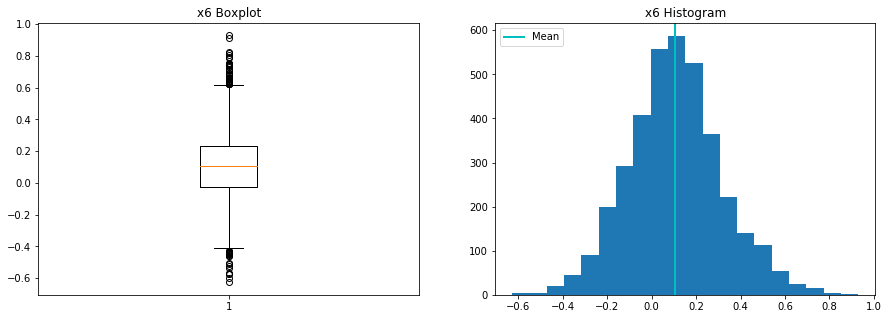

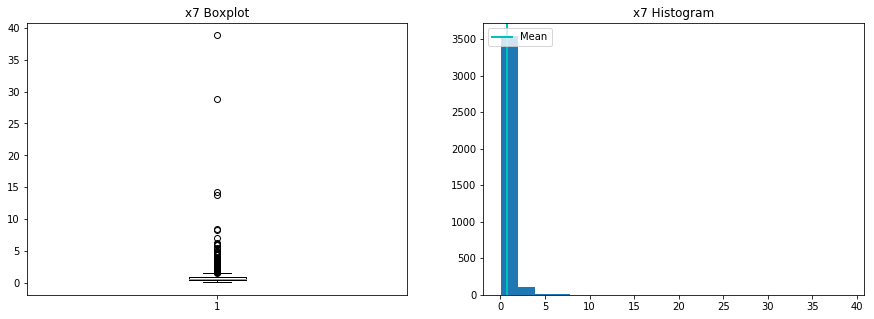

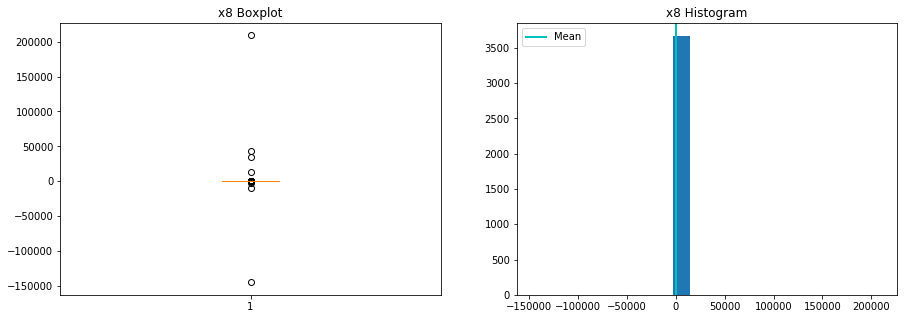

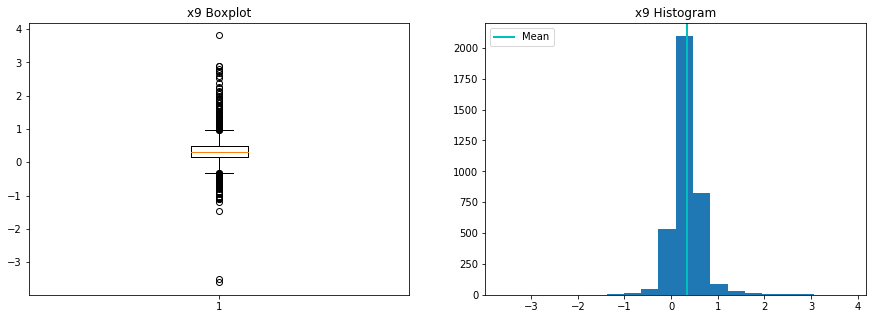

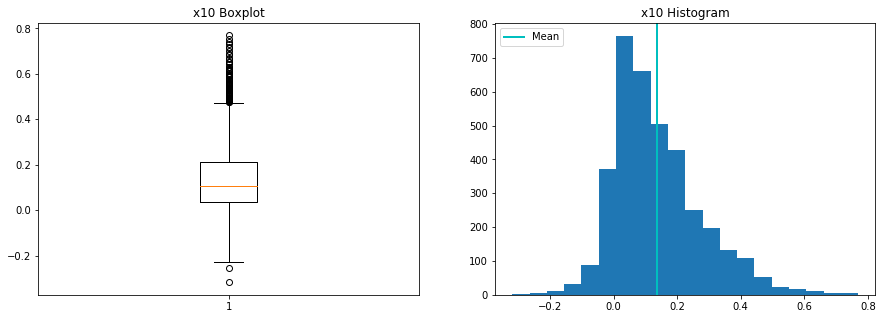

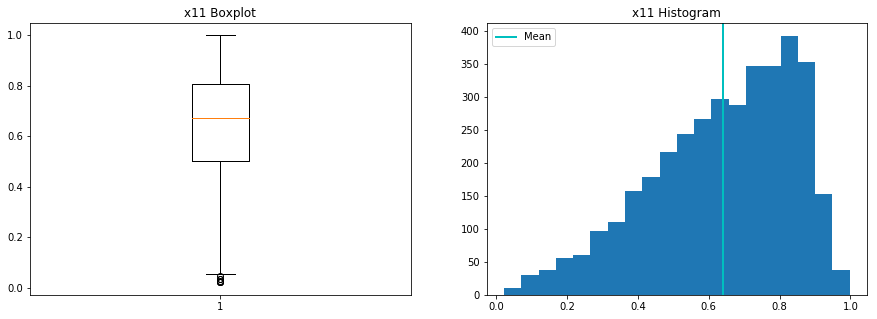

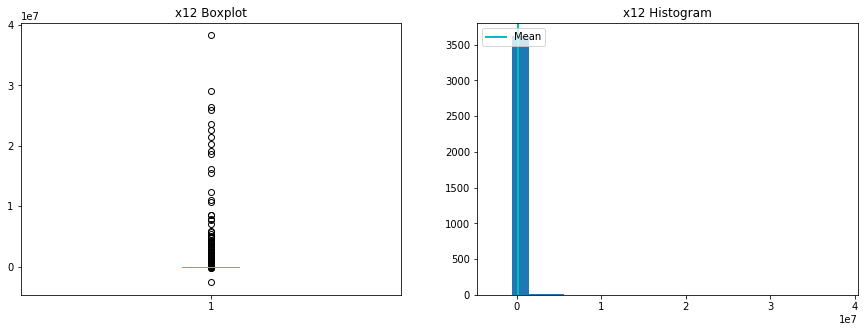

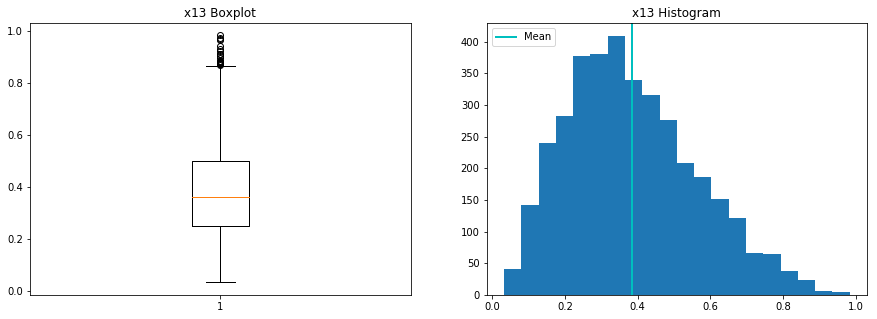

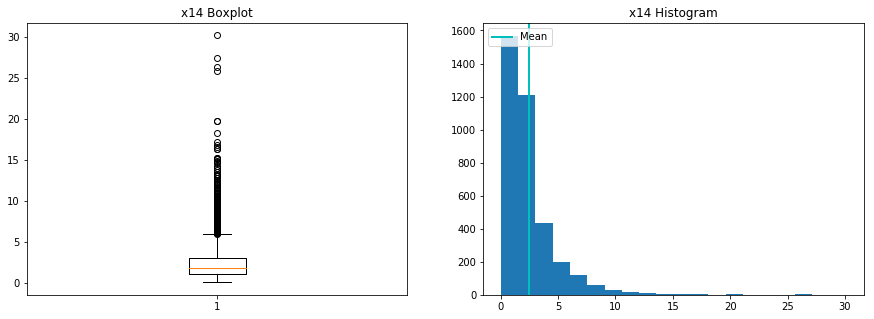

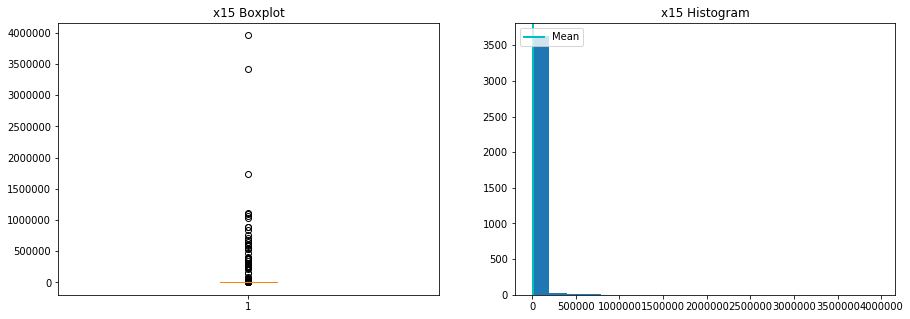

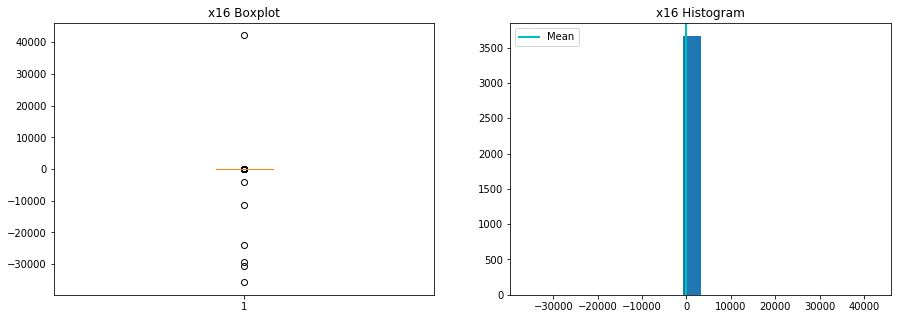

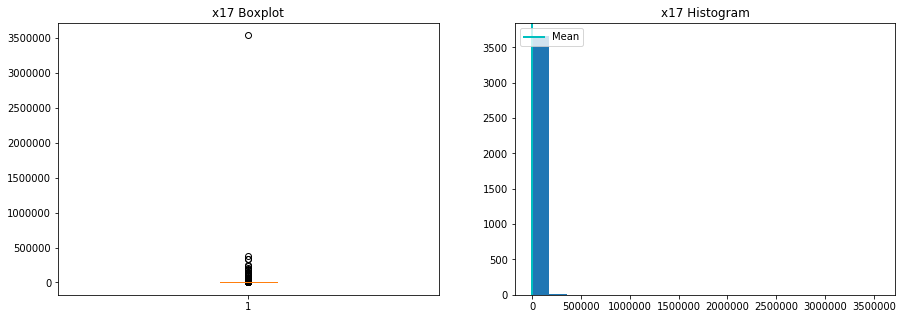

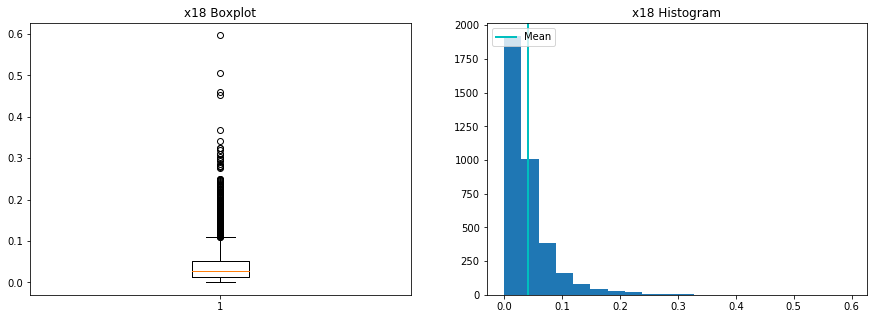

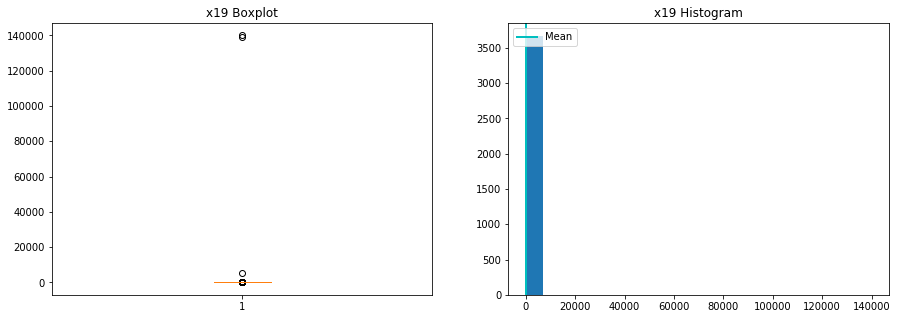

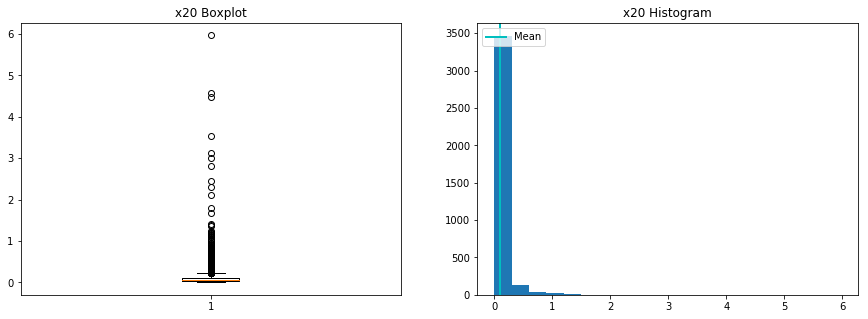

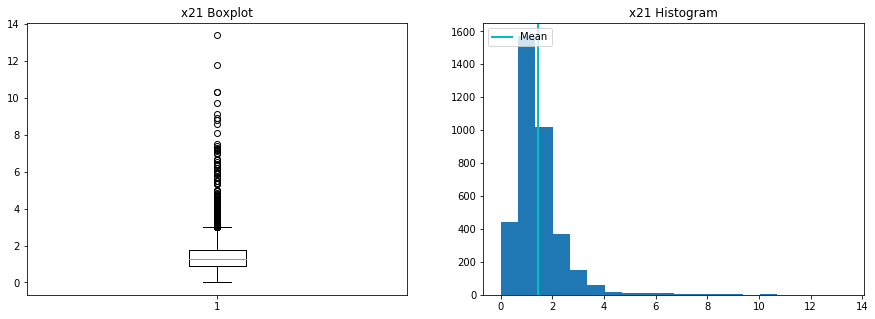

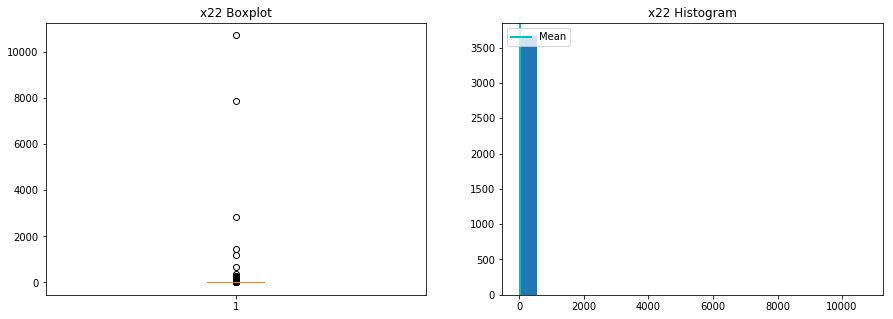

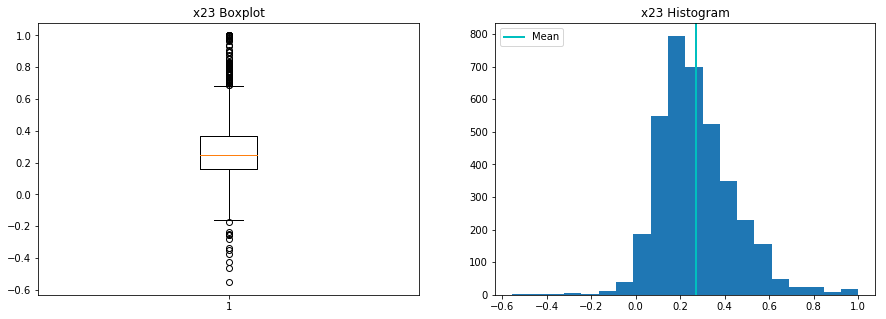

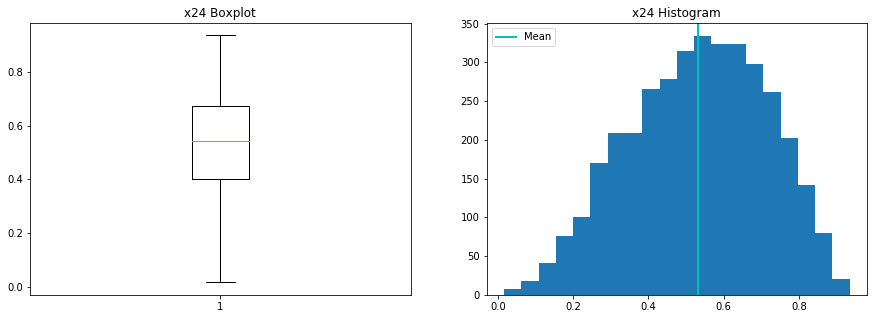

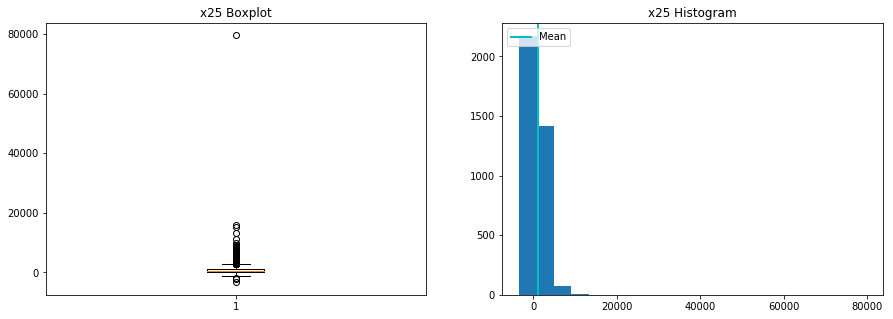

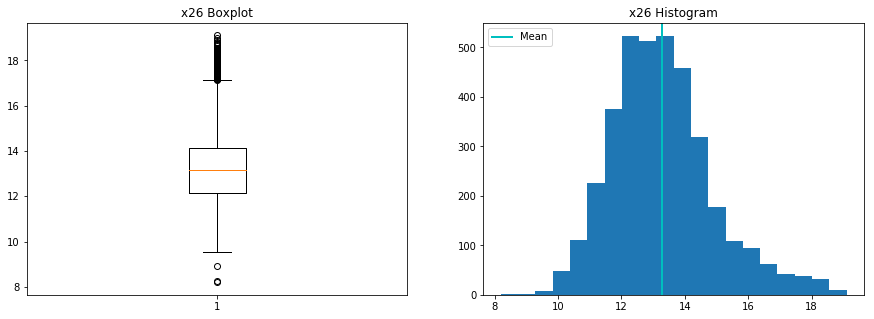

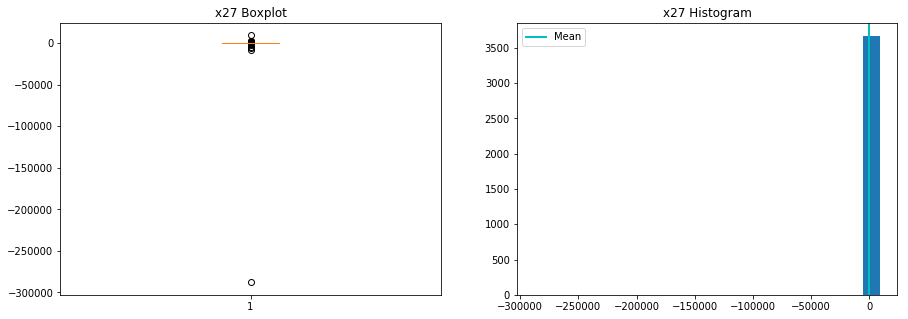

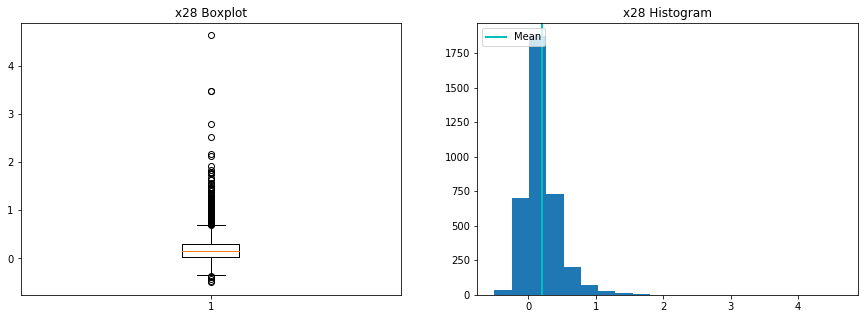

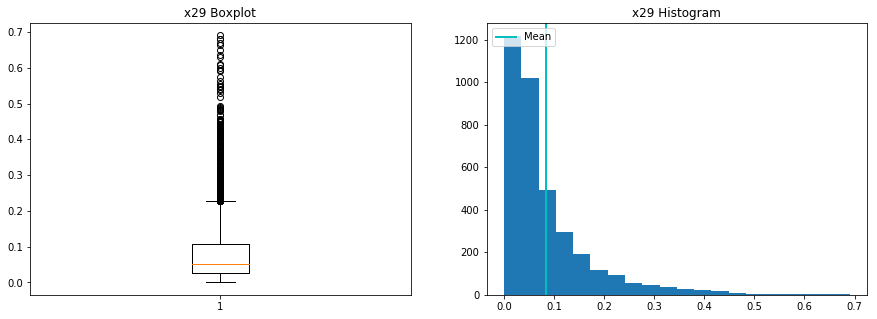

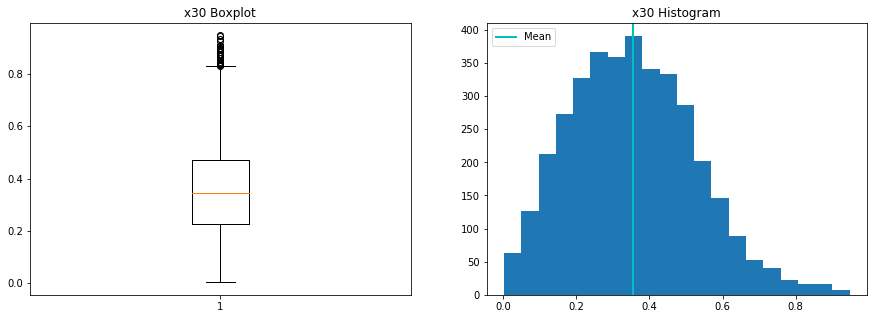

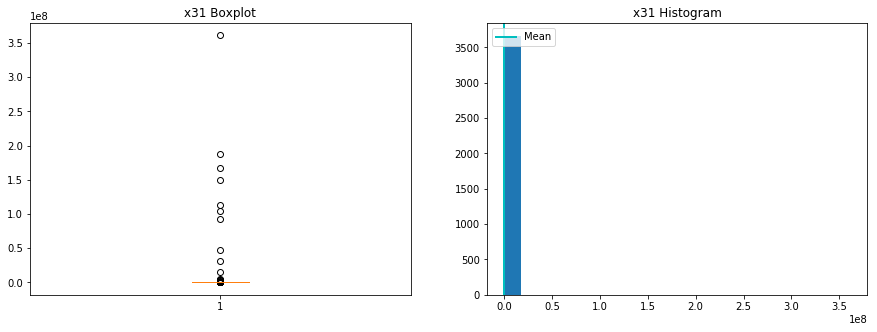

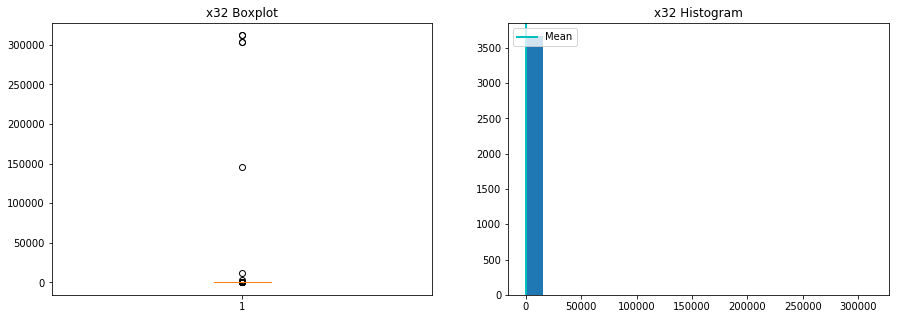

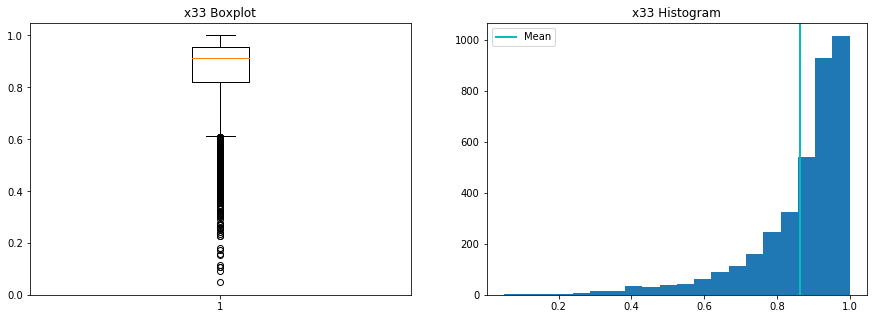

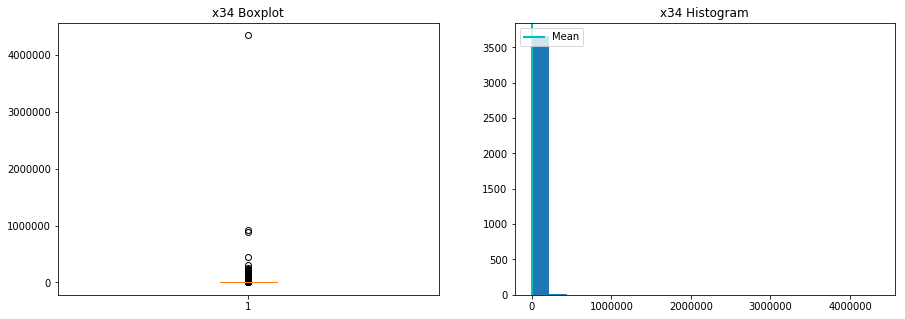

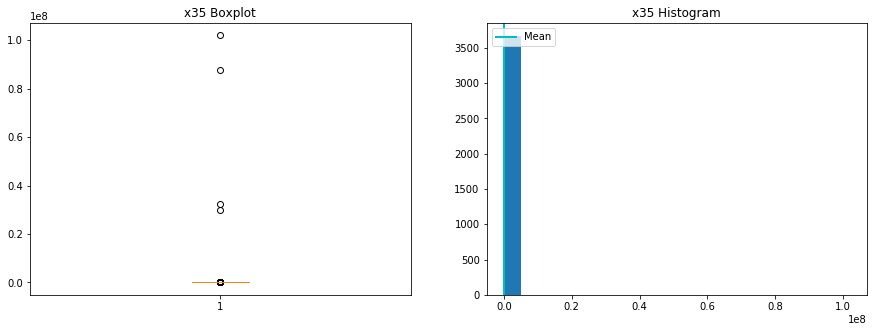

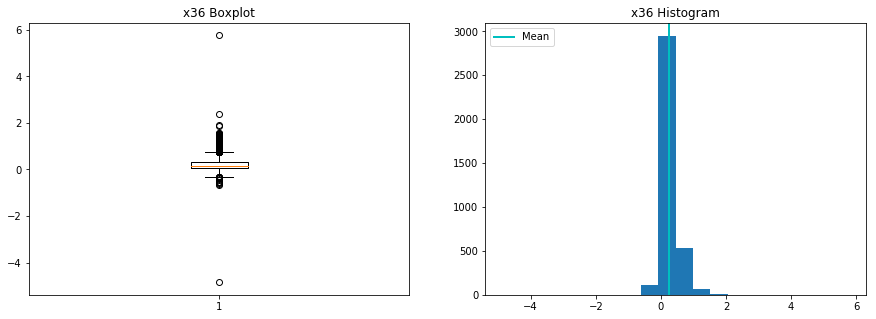

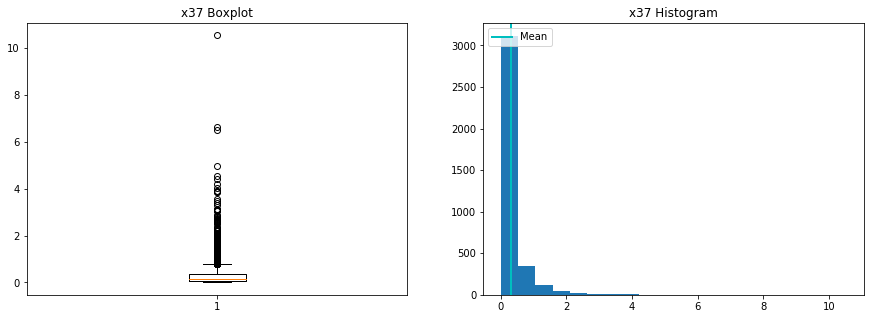

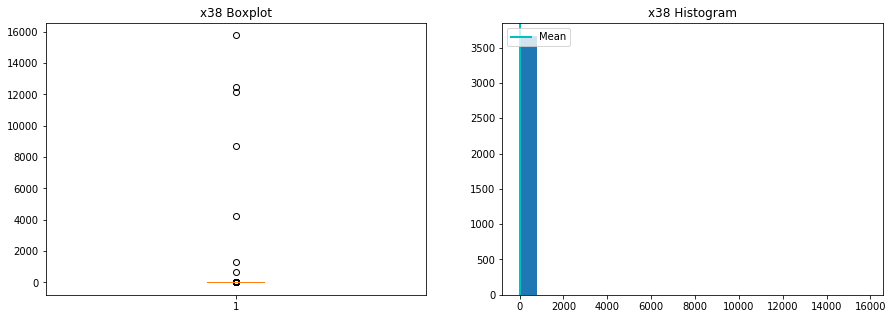

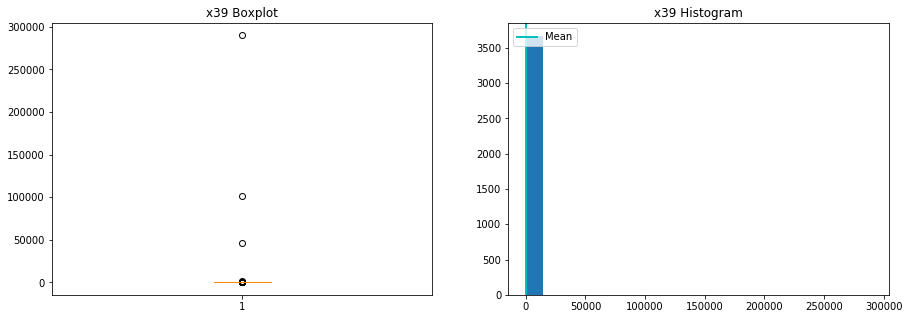

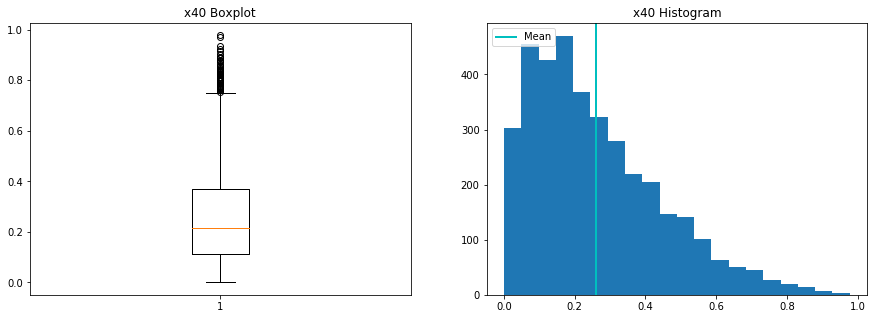

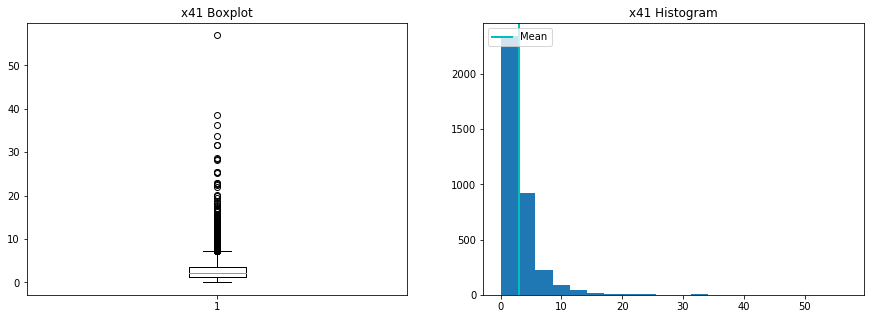

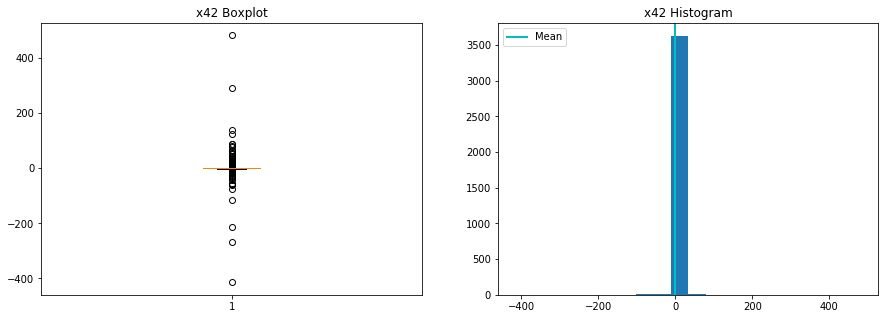

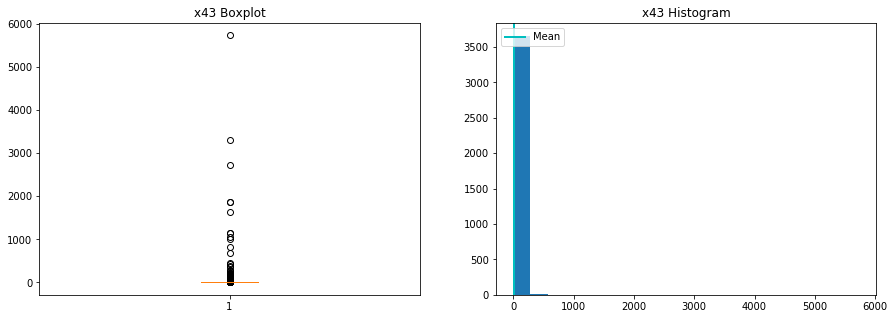

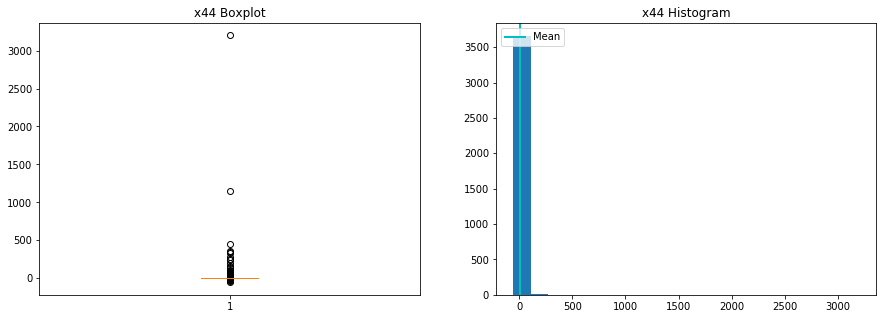

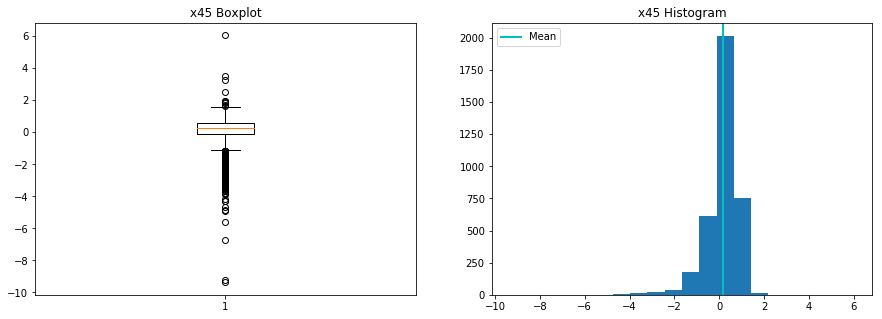

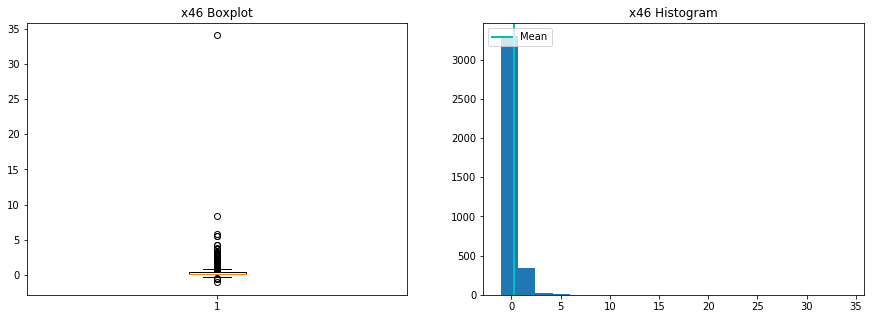

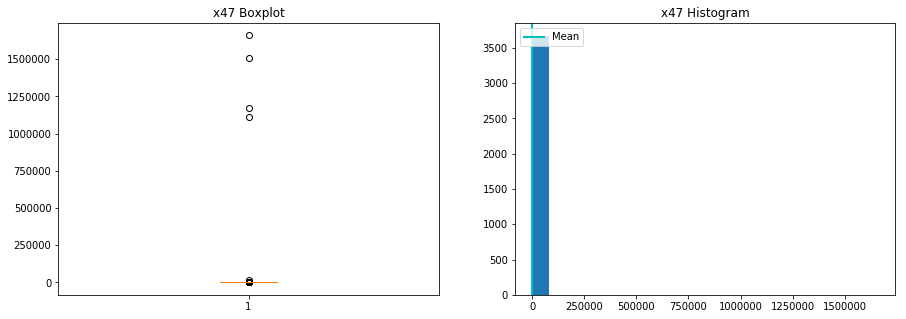

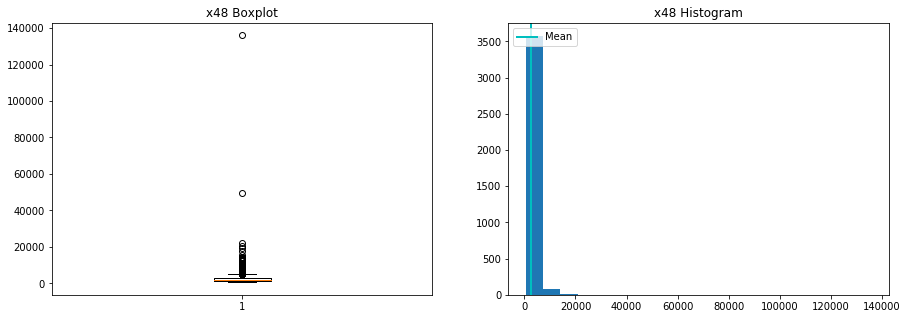

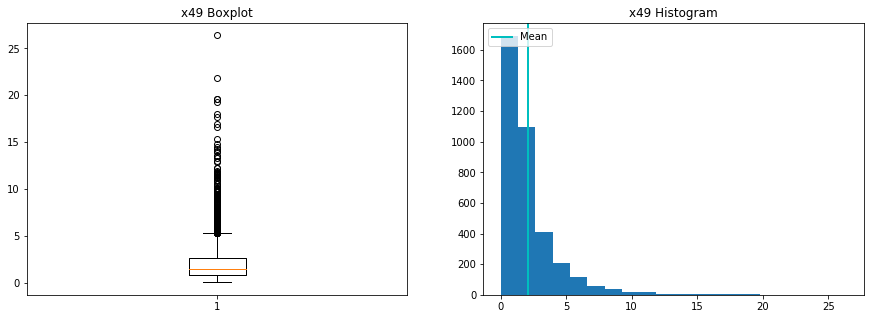

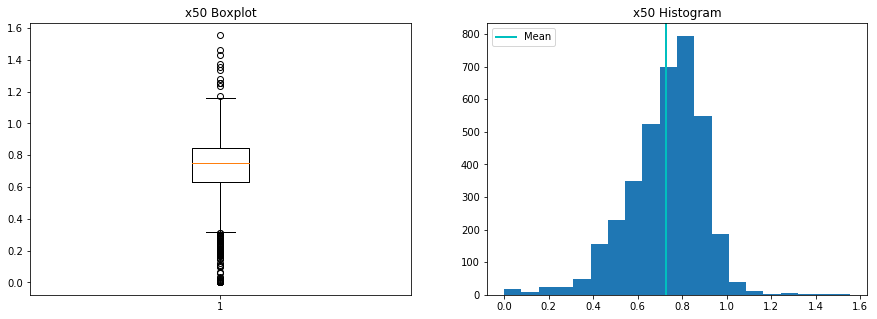

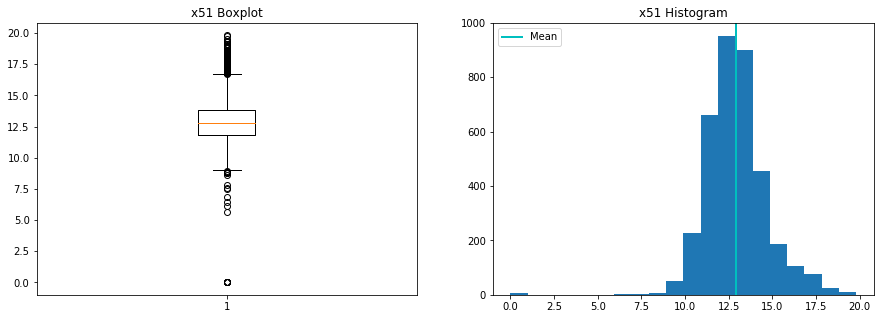

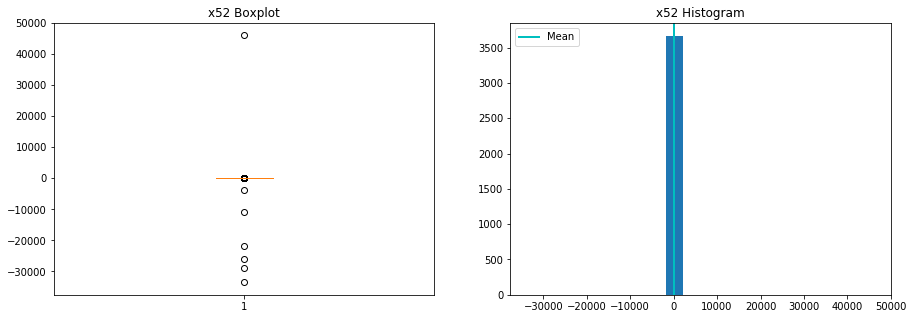

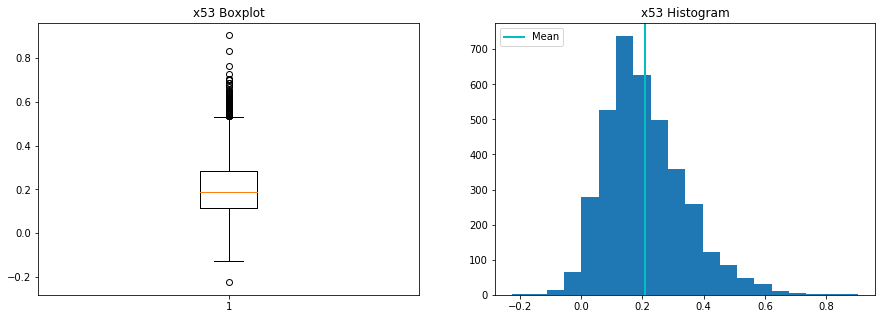

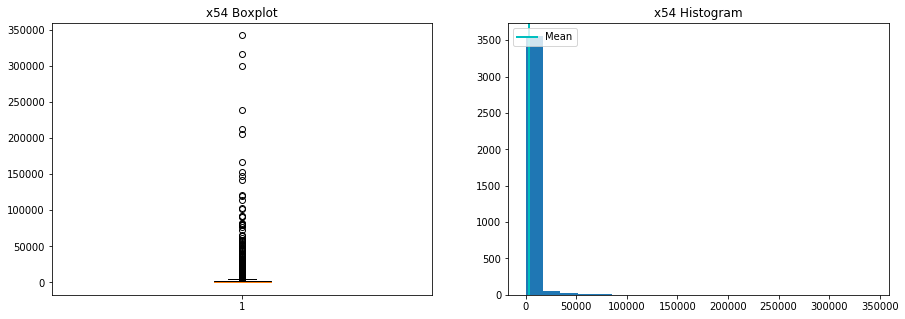

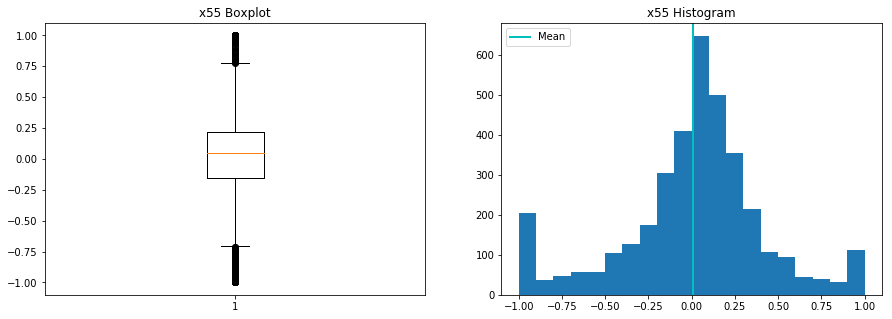

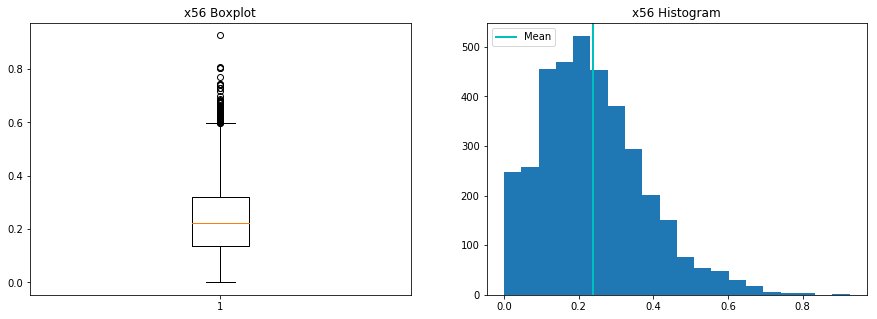

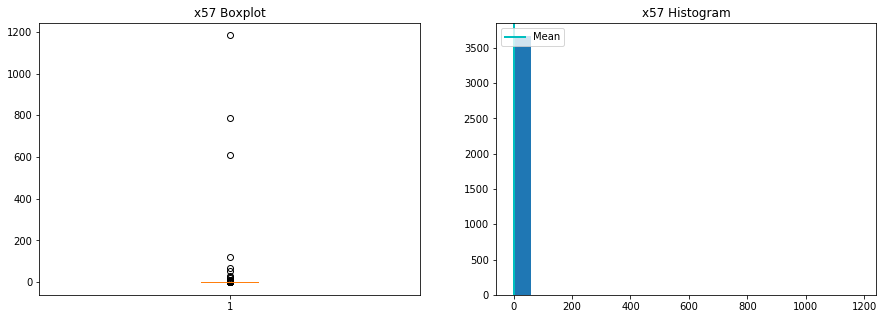

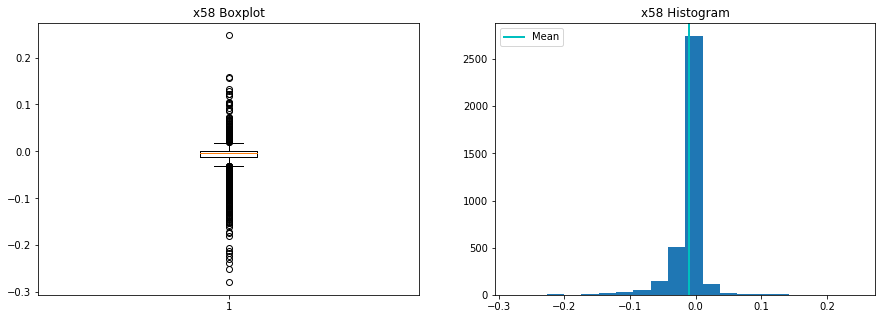

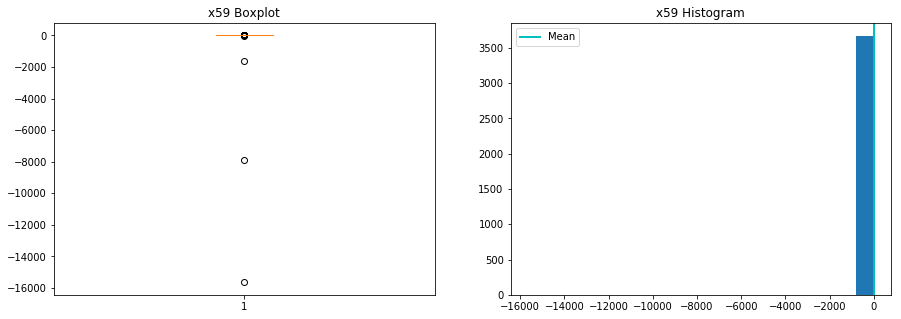

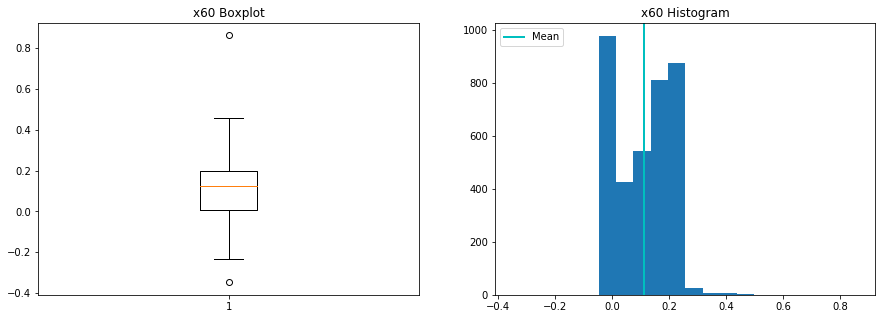

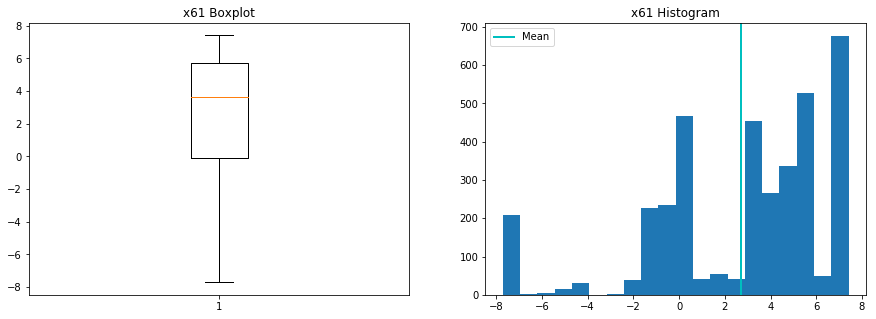

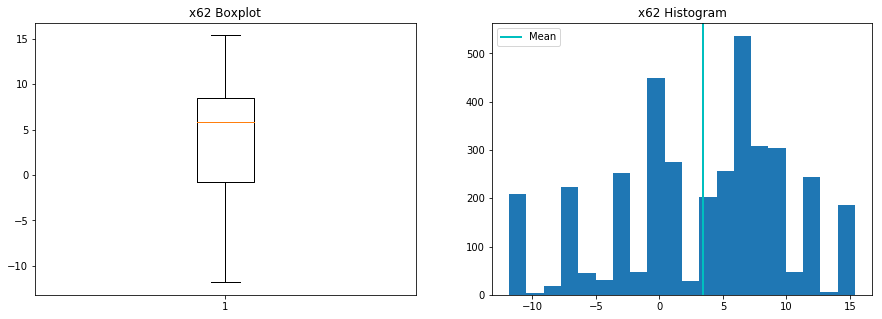

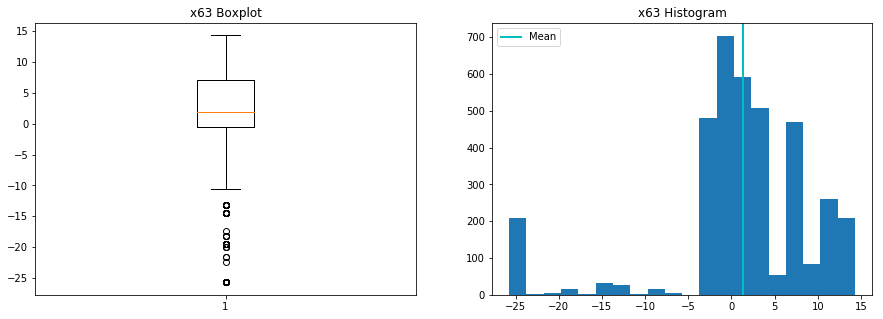

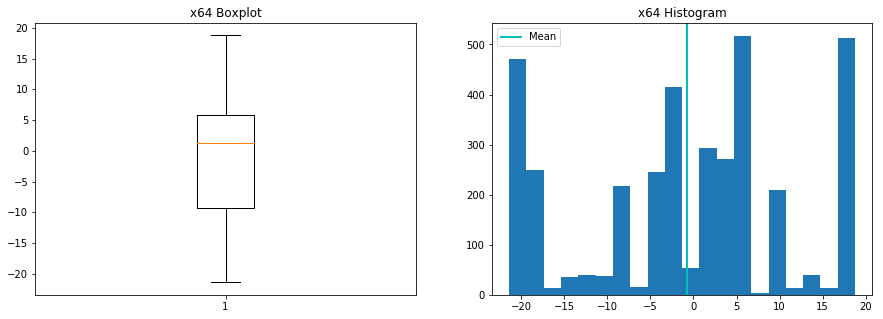

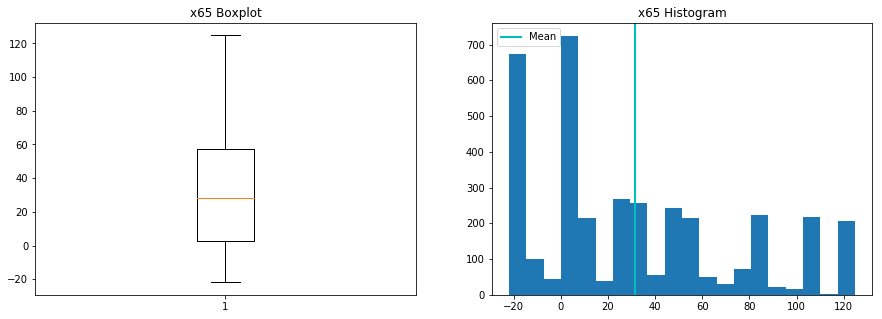

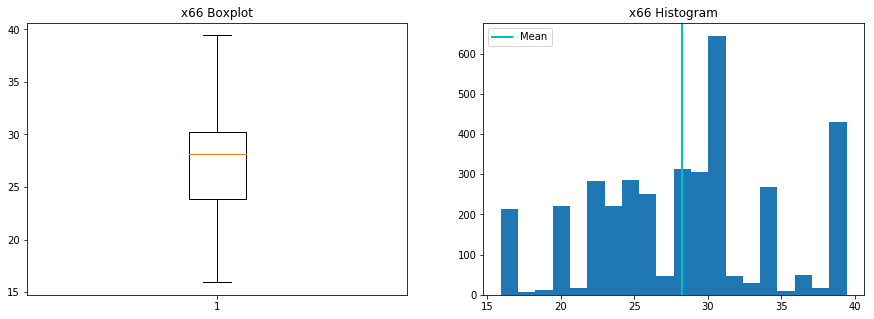

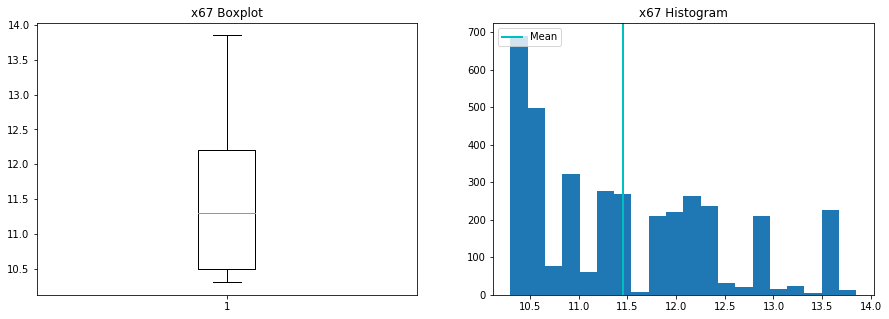

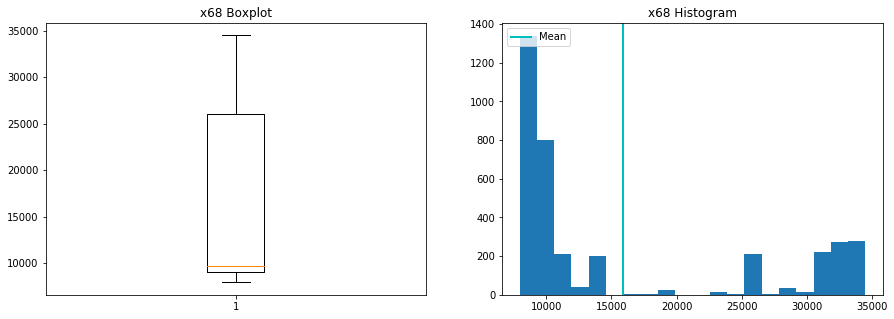

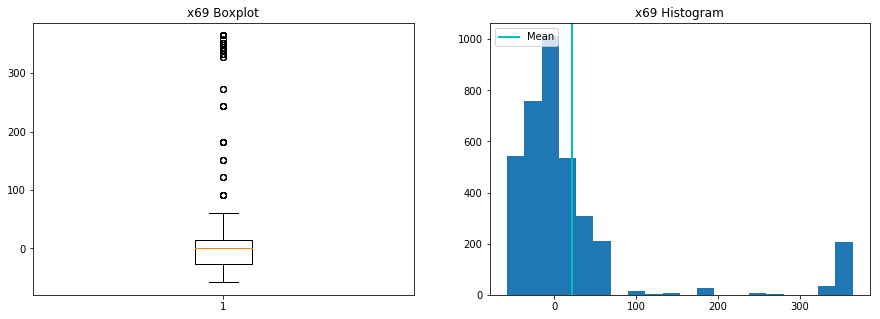

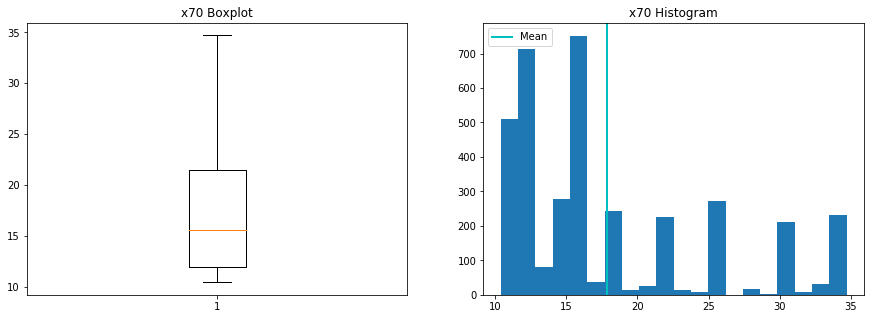

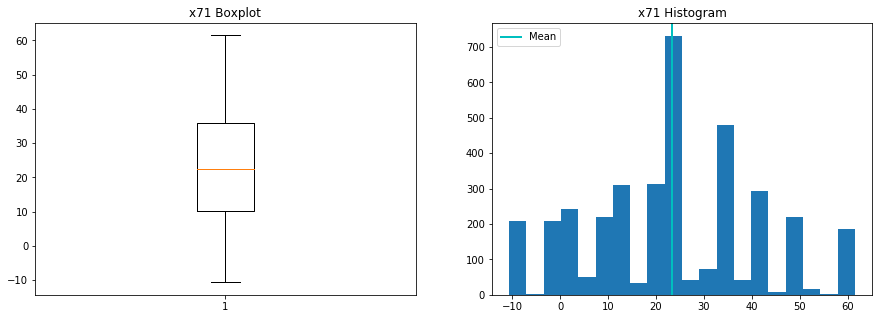

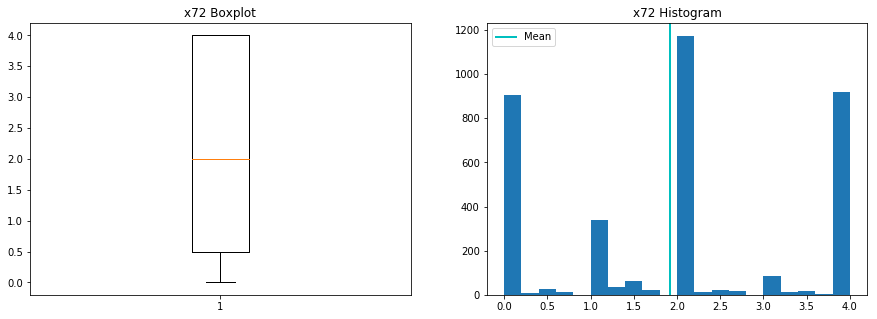

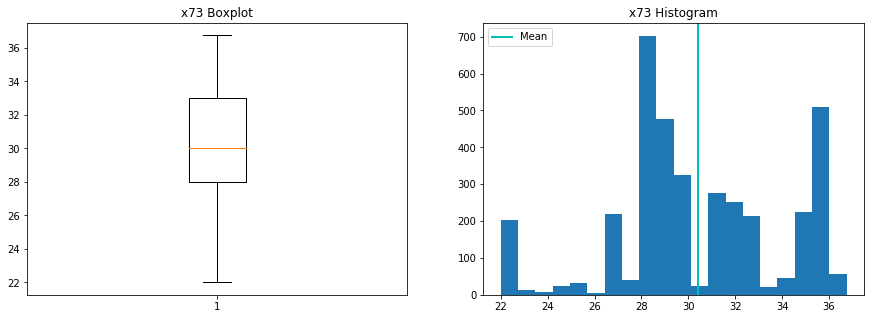

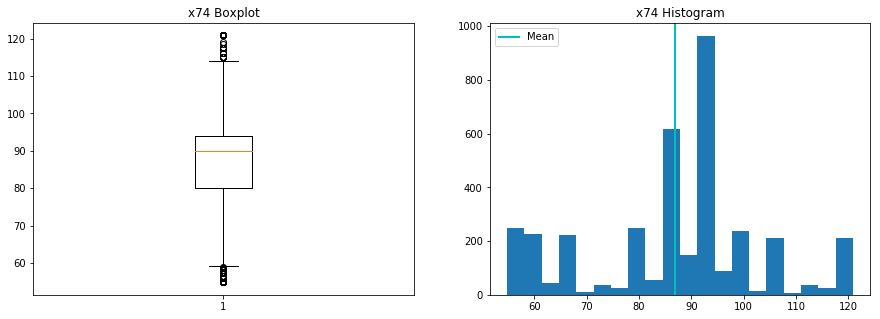

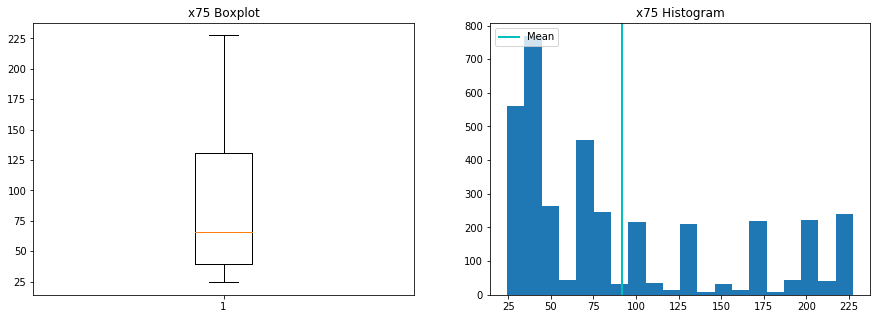

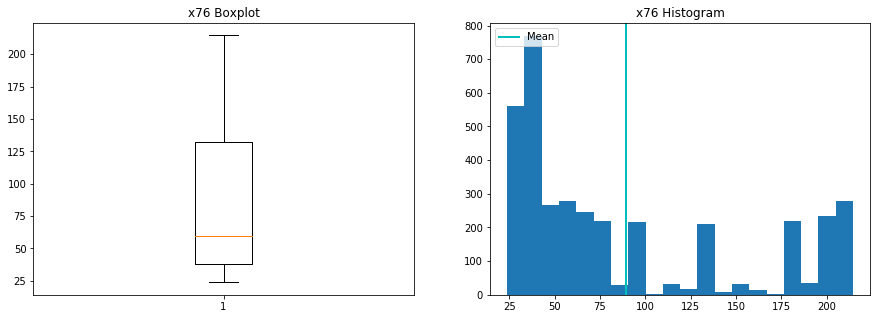

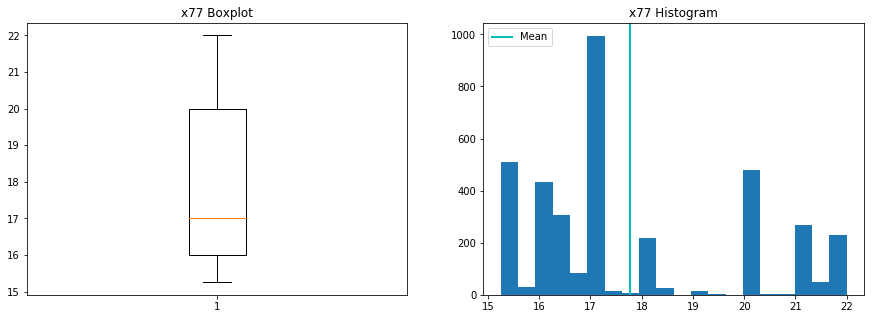

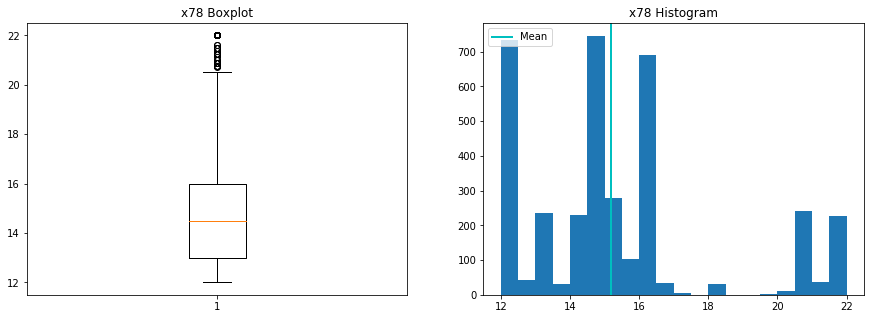

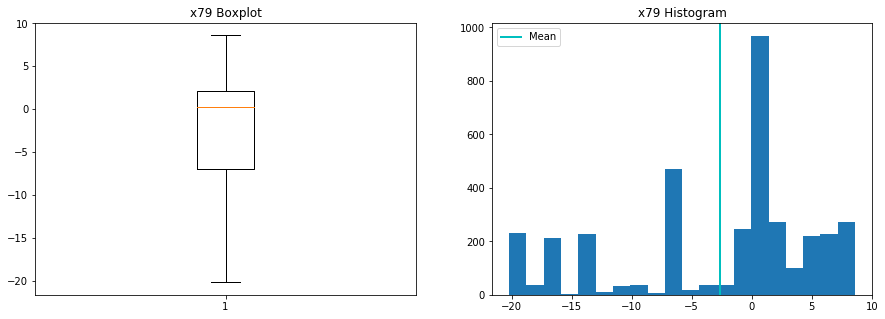

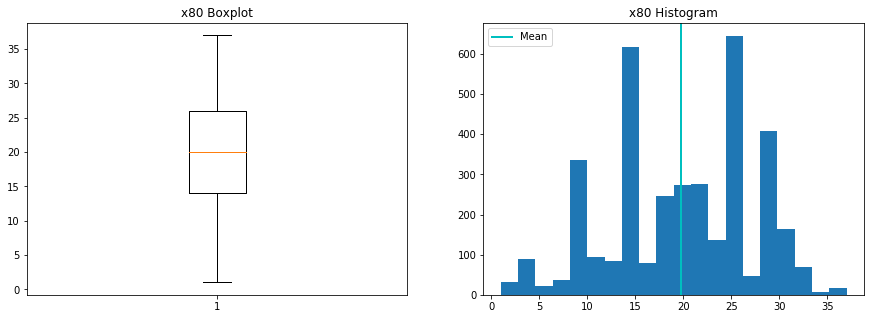

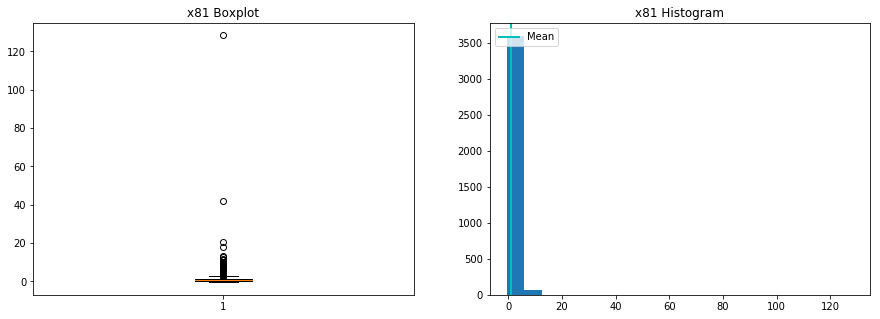

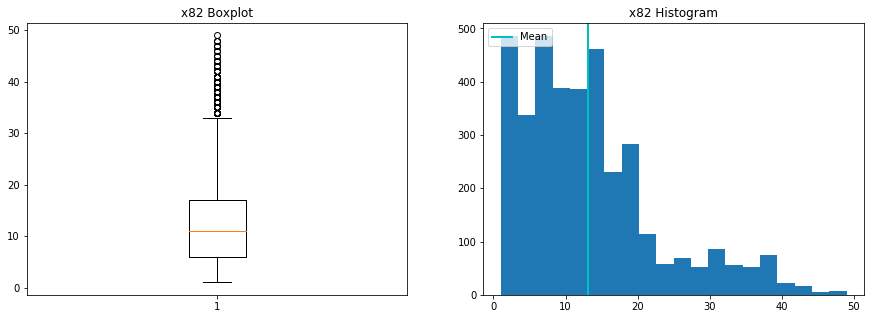

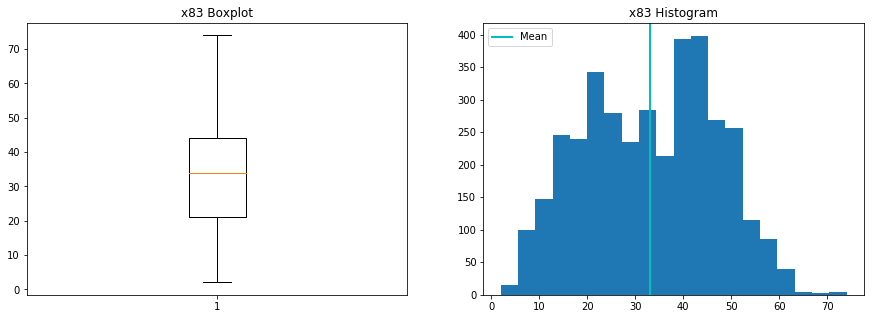

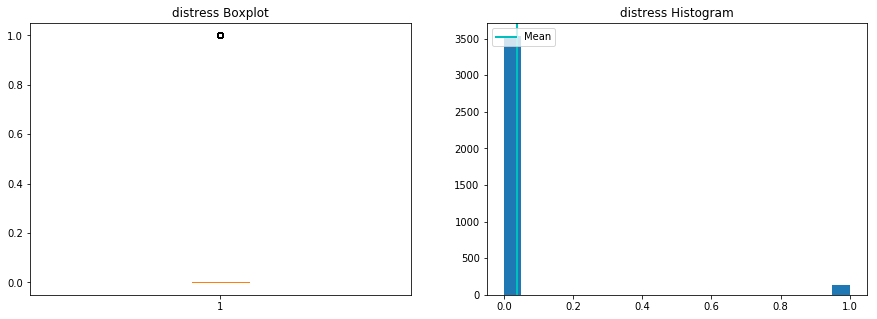

In [59]:
from pandas.api.types import is_numeric_dtype

# Visualize distributions of each column
for column in financial:
    
    if is_numeric_dtype(financial[column]):
    
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.boxplot(financial[column].dropna(how = 'any'))
        plt.title(column + ' Boxplot')

        plt.subplot(1, 2, 2)
        plt.hist(financial[column].dropna(how = 'any'), bins=20)
        plt.axvline(financial[column].mean(), color='c', linestyle='solid', linewidth=2, label="Mean")
        plt.legend(loc='upper left') 
        plt.title(column + ' Histogram')

        plt.show()

### Prepare for models

Since out purposes are classification, we will ignore the time values and look at the financial indicators of each record.

The documentation describes the classification of financial distress as scores below -0.5, so we'll create a new binary classification feature.

In [7]:
financial['distress'] = 0

financial.loc[financial['Financial Distress'] < -0.5, 'distress'] = 1

In [8]:
financial.distress.value_counts()

0    3536
1     136
Name: distress, dtype: int64

In [9]:
X = financial.drop(['Company', 'Time', 'Financial Distress'], 1)

Y = financial.distress

In [10]:
Y.value_counts()/len(Y)

0    0.962963
1    0.037037
Name: distress, dtype: float64

Since the purpose of this exercise is practice with the models, we'll downsample to handle the class imbalance

In [11]:
# Downsample to balance the distress class

# Separate majority and minority classes
financial_majority = financial[financial.distress==0]
financial_minority = financial[financial.distress==1]
 
# Upsample minority class
financial_majority_downsampled = resample(financial_majority, replace=True, n_samples=136) 
 
# Combine majority class with upsampled minority class
financial_downsample = pd.concat([financial_minority, financial_majority_downsampled])
 
# Display new class counts
financial_downsample.distress.value_counts()

1    136
0    136
Name: distress, dtype: int64

In [12]:
X = financial_downsample.drop(['Company', 'Time', 'Financial Distress'], 1)

Y = financial_downsample.distress

In [14]:
Y.value_counts()/len(Y)

1    0.5
0    0.5
Name: distress, dtype: float64

Now we have a perfectly balanced class.

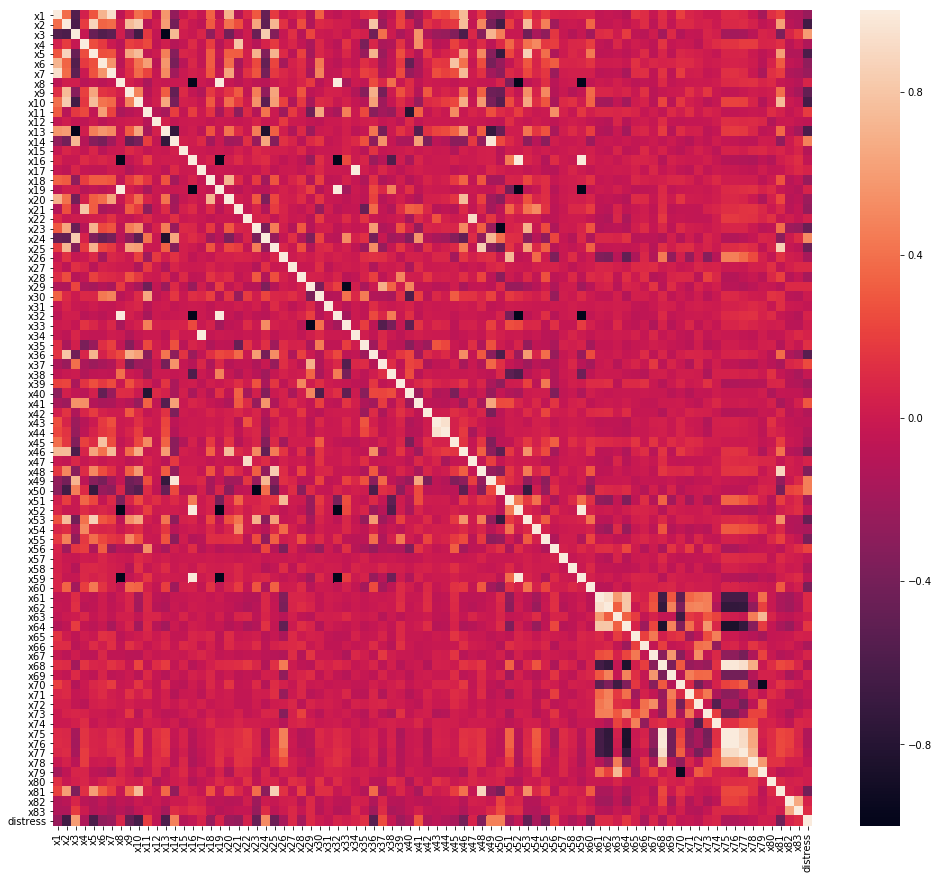

In [51]:
corr = X.corr()

plt.figure(figsize=(17, 15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

A few points of noticeable correlation, but most features show minimal correlation.

### Model Metrics

In [35]:
def model_results(model):
    start_time= time.clock()
    model.fit(X, Y)
    end_time = time.clock()
    score = cross_val_score(model, X, Y, cv=5)
    print("Time to fit: ", end_time - start_time)
    print("\nCross Validation Scores:\n", score)
    print("\nCross Validation range: %0.2f to %0.2f" % (score.min(), score.max()))
    print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# MLP Classifier

In [36]:
# Use default settings
# hidden_layer_sizes = (100,), solver = ‘adam’, alpha = 0.0001, max_iter = 200
mlp = MLPClassifier()

In [37]:
model_results(mlp)

Time to fit:  0.08724200000000071

Cross Validation Scores:
 [0.5        0.48148148 0.51851852 0.61111111 0.77777778]

Cross Validation range: 0.48 to 0.78

Cross Validation mean of: 0.58 (+/- 0.22)


Using default settings on MLP, we get slightly better than base accuracy and overfitting.<br>
Let's try some tuning.

### Adding layers

In [38]:
mlp2 = MLPClassifier(hidden_layer_sizes = (100,100))

In [39]:
model_results(mlp2)

Time to fit:  0.05718699999999988

Cross Validation Scores:
 [0.53571429 0.75925926 0.68518519 0.59259259 0.46296296]

Cross Validation range: 0.46 to 0.76

Cross Validation mean of: 0.61 (+/- 0.21)


That improved average accuracy, but not overfitting.

In [40]:
mlp3 = MLPClassifier(hidden_layer_sizes = (100,100,100))

In [41]:
model_results(mlp3)

Time to fit:  0.21794099999999972

Cross Validation Scores:
 [0.51785714 0.53703704 0.68518519 0.66666667 0.72222222]

Cross Validation range: 0.52 to 0.72

Cross Validation mean of: 0.63 (+/- 0.16)


Now we've improved accuracy and some reduction in overfitting, but at the cost of time to fit.

### Adding iterations

In [44]:
mlp4 = MLPClassifier(hidden_layer_sizes = (100,100,100), max_iter = 100)

In [45]:
model_results(mlp4)

Time to fit:  0.21126999999999985

Cross Validation Scores:
 [0.48214286 0.81481481 0.66666667 0.62962963 0.72222222]

Cross Validation range: 0.48 to 0.81

Cross Validation mean of: 0.66 (+/- 0.22)


### Grid Search CV

In [68]:
parameters = {'hidden_layer_sizes': np.arange(10,100,10),
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha' : np.arange(0.0001,0.001,0.0001),
    'max_iter' : np.arange(100,1000,100)}
mlp = MLPClassifier()
mlp_cv = GridSearchCV(mlp, parameters)

In [69]:
mlp_cv.fit(X, Y)
mlp_cv.best_params_

{'alpha': 0.0005, 'hidden_layer_sizes': 90, 'max_iter': 900, 'solver': 'lbfgs'}

In [70]:
mlp5 = MLPClassifier(alpha=0.0005, hidden_layer_sizes=90, max_iter=900, solver='lbfgs')

In [71]:
model_results(mlp5)

Time to fit:  0.05275700000015604

Cross Validation Scores:
 [0.46428571 0.51851852 0.46296296 0.75925926 0.51851852]

Cross Validation range: 0.46 to 0.76

Cross Validation mean of: 0.54 (+/- 0.22)


Grid Search CV did not produce very good results.  Perhaps more limited testing is un order.

In [72]:
parameters = {'hidden_layer_sizes': np.arange(20,200,20),
    'alpha' : np.arange(0.0001,0.001,0.0001),
    'max_iter' : np.arange(100,1000,100)}
mlp = MLPClassifier()
mlp_cv = GridSearchCV(mlp, parameters)

In [73]:
mlp_cv.fit(X, Y)
mlp_cv.best_params_

{'alpha': 0.0004, 'hidden_layer_sizes': 140, 'max_iter': 800}

In [75]:
mlp6 = MLPClassifier(alpha=0.0004, hidden_layer_sizes=140, max_iter=800)

In [76]:
model_results(mlp6)

Time to fit:  0.06227800000010575

Cross Validation Scores:
 [0.71428571 0.61111111 0.59259259 0.64814815 0.48148148]

Cross Validation range: 0.48 to 0.71

Cross Validation mean of: 0.61 (+/- 0.15)


In [87]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha' : np.arange(0.0001,0.001,0.0001),
    'max_iter' : np.arange(100,1000,100)}
mlp = MLPClassifier(hidden_layer_sizes = [100,100,100])
mlp_cv = GridSearchCV(mlp, parameters)

In [88]:
mlp_cv.fit(X, Y)
mlp_cv.best_params_

{'alpha': 0.0001, 'max_iter': 900, 'solver': 'adam'}

In [89]:
mlp7 = MLPClassifier(alpha=0.0001, hidden_layer_sizes=[100,100], max_iter=900)

In [90]:
model_results(mlp7)

Time to fit:  0.09721400000012181

Cross Validation Scores:
 [0.73214286 0.72222222 0.61111111 0.68518519 0.68518519]

Cross Validation range: 0.61 to 0.73

Cross Validation mean of: 0.69 (+/- 0.09)


Best result with a Multi-Layer Perceptron Model is an average of 69% accuracy with a 12 point range of cross validation scores, so there is still over-fitting.

# Random Forest Classifier

Let's start by using the default settings for Random Forest.  And since tree-based models deal well with class imbalance on their own, let's try the original data before upsampling.

In [46]:
# Use default settings
# n_estimators = 10, criterion = ”gini”, 
rfc = ensemble.RandomForestClassifier()

In [47]:
model_results(rfc)

Time to fit:  0.028607000000000937

Cross Validation Scores:
 [0.96428571 0.98148148 0.98148148 0.88888889 0.96296296]

Cross Validation range: 0.89 to 0.98

Cross Validation mean of: 0.96 (+/- 0.07)


In [57]:
parameters = {'n_estimators': np.arange(10,100,10),
    'max_features': np.arange(2,82,10),
    'max_depth' : [1, 2, 10, 15],
    'criterion' : ['gini', 'entropy']}
rfc = ensemble.RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, parameters)

In [58]:
rfc_cv.fit(X, Y)
rfc_cv.best_params_

{'criterion': 'gini', 'max_depth': 1, 'max_features': 32, 'n_estimators': 20}

In [61]:
rfc2 = ensemble.RandomForestClassifier(criterion='gini', max_depth=1, max_features=32, n_estimators=20)

In [62]:
model_results(rfc2)

Time to fit:  0.04892300000000205

Cross Validation Scores:
 [0.83928571 0.96296296 1.         0.87037037 1.        ]

Cross Validation range: 0.84 to 1.00

Cross Validation mean of: 0.93 (+/- 0.13)


The best result with Random Forest generates average accuracy of 93% with some overfitting (range of 17).

## Conclusions

In this case, with this small dataset, the Random Forest shows significantly greater accuracy than Multi-Layer Perceptrons.  The overfitting is reduced with MLP, but not enough to offset the improved accuracy, making Random FOrest a better fit for the data.